In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os
import collections
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata
import fastai
import fastai.vision

# Fast AI Time Series Competition No1: Earthquakes.

Data is already downloaded in `../data/`.

## Data Loading

In [2]:
data_path = pathlib.Path('../data')
archive = 'UCR_TS_Archive_2015'
batch_size = 128

In [3]:
datasets = os.listdir(data_path/archive)

In [4]:
ucr_id = 'Adiac'

In [5]:
train = np.loadtxt(data_path/archive/ucr_id/'{}_TRAIN'.format(ucr_id), delimiter=',')
test = np.loadtxt(data_path/archive/ucr_id/'{}_TEST'.format(ucr_id), delimiter=',')

In [6]:
train.shape, test.shape

((390, 177), (391, 177))

In [7]:
train, train_labels = train[:, 1:], train[:, 0].astype(np.int)
test, test_labels = test[:, 1:], test[:, 0].astype(np.int)

In [8]:
train_labels = train_labels - np.min(train_labels)
test_labels = test_labels - np.min(test_labels)

In [13]:
np.max(train_labels), np.max(test_labels)

(36, 36)

In [14]:
train_ds = torchdata.TensorDataset(
    torch.tensor(train, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.int64))
test_ds = torchdata.TensorDataset(
    torch.tensor(test, dtype=torch.float32),
    torch.tensor(test_labels, dtype=torch.int64))

In [15]:
data = fastai.DataBunch.create(train_ds, test_ds, bs=batch_size)

## LSTM-FCNN
This is a reimplementation of the LSTM-FCNN from https://ieeexplore-ieee-org.ezproxy.cul.columbia.edu/ielx7/6287639/8274985/08141873.pdf?tp=&arnumber=8141873&isnumber=8274985&tag=1

The reported accuracy on the Earthquakes dataset in the paper is .8354.

In [16]:
class ConvLayer(nn.Module):
    def __init__(self, in_channels=1, n_channels=128, kernel_size=8, dropout=0.0):
        super().__init__()
        self.conv = nn.Conv1d(in_channels=in_channels,
                             out_channels=n_channels,
                             kernel_size=kernel_size)
        self.bn = nn.BatchNorm1d(num_features=n_channels)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # input size should be batch, input_size, length = 64, 1, 312 at first
        x = self.conv(x)
        # now batch, n_channels, L
        x = self.bn(x)
        x = F.relu(x)
        # output will be bs, n_filters, L (not equal to inital L)
        return self.dropout(x)
    

In [17]:
class FCNN(nn.Module):
    def __init__(self,
                 seq_length,
                 conv_n_channels=[128, 256, 128],
                 conv_kernel_sizes=[8, 5, 3],
                 n_categories=2
                 ):
        
        super().__init__()
        
        self.conv1 = ConvLayer(1, conv_n_channels[0], conv_kernel_sizes[0])  
        self.conv2 = ConvLayer(conv_n_channels[0], conv_n_channels[1], conv_kernel_sizes[1])  
        self.conv3 = ConvLayer(conv_n_channels[1], conv_n_channels[2], conv_kernel_sizes[2])  
        
        # global pool is avg pool using the length of the resulting TS
        # we need to calculate this:
        out_len = seq_length - sum(conv_kernel_sizes) + len(conv_kernel_sizes)
        self.global_avg_pool = nn.AvgPool1d(kernel_size = out_len)
        
        
        self.linear = nn.Linear(conv_n_channels[-1], n_categories)
        
        
        
    def forward(self, x):
        # our input is batch, seq_len
        x = x.unsqueeze(1)
        # batch, 1, seq_len
        
        
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # x is now bs, dimension, L
        
        x = self.global_avg_pool(x)
        # bs, dimension, 1
        out = torch.squeeze(x)
        # bs, dimension
        
        
        return self.linear(out)


## Training

In [18]:
len(train[0])

176

In [19]:
max(train_labels)

36

In [57]:
model = FCNN(len(train[0]), n_categories=max(train_labels)+1)

In [58]:
counts = collections.Counter(train_labels)

In [59]:
weights = [len(train_labels)/counts[i] for i in np.arange(len(counts))]

In [60]:
#loss = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32))
loss = nn.CrossEntropyLoss()
loss.cuda()

CrossEntropyLoss()

In [61]:
learner = fastai.Learner(data, model, loss_func=loss, metrics=[fastai.accuracy])
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


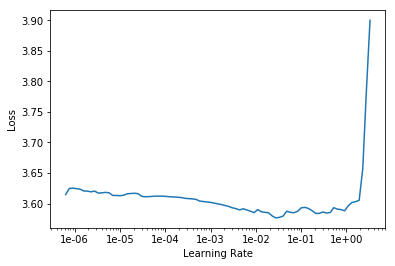

In [36]:
learner.lr_find(); learner.recorder.plot()

In [63]:
learner.fit(500, lr=1e-3)

Total time: 12:10
epoch  train_loss  valid_loss  accuracy
1      3.628871    3.610752    0.017903  (00:01)
2      3.623399    3.610670    0.025575  (00:01)
3      3.610075    3.610807    0.035806  (00:01)
4      3.594817    3.612109    0.035806  (00:01)
5      3.585153    3.611587    0.051151  (00:01)
6      3.580452    3.610146    0.053708  (00:01)
7      3.564059    3.605959    0.030691  (00:01)
8      3.546870    3.596578    0.028133  (00:01)
9      3.531890    3.587937    0.028133  (00:01)
10     3.516168    3.576812    0.028133  (00:01)
11     3.498823    3.547749    0.030691  (00:01)
12     3.478470    3.523802    0.040921  (00:01)
13     3.464910    3.500743    0.030691  (00:01)
14     3.454561    3.452803    0.092072  (00:01)
15     3.429872    3.425347    0.086957  (00:01)
16     3.403802    3.403213    0.071611  (00:01)
17     3.378765    3.376208    0.099744  (00:01)
18     3.357239    3.337379    0.117647  (00:01)
19     3.345912    3.303995    0.117647  (00:01)
20     3.33

In [64]:
learner.fit(500, lr=1e-3/5)

Total time: 12:10
epoch  train_loss  valid_loss  accuracy
1      0.869472    2.661484    0.273657  (00:01)
2      0.788826    1.042203    0.641944  (00:01)
3      0.799835    0.910675    0.703325  (00:01)
4      0.831503    1.010632    0.693095  (00:01)
5      0.790137    1.149375    0.593350  (00:01)
6      0.774253    0.927472    0.708440  (00:01)
7      0.808803    0.944355    0.741688  (00:01)
8      0.796017    0.879719    0.764706  (00:01)
9      0.788109    0.990559    0.700767  (00:01)
10     0.790321    0.893698    0.718670  (00:01)
11     0.775503    0.853347    0.731458  (00:01)
12     0.763584    0.831144    0.754476  (00:01)
13     0.761626    0.794099    0.772379  (00:01)
14     0.782138    0.803363    0.767263  (00:01)
15     0.797240    0.938171    0.700767  (00:01)
16     0.787856    0.996029    0.675192  (00:01)
17     0.795055    0.896848    0.736573  (00:01)
18     0.782453    0.880580    0.739130  (00:01)
19     0.772017    0.846051    0.762148  (00:01)
20     0.77

In [ ]:
learner.fit(500, lr=1e-4)

epoch,train_loss,valid_loss,accuracy
1,0.558246,0.737728,0.751918
2,0.467592,0.696466,0.795396
3,0.459848,0.660598,0.782609
4,0.461668,0.656595,0.787724
5,0.438165,0.630403,0.805627
6,0.606059,0.670173,0.787724
7,0.598852,0.692501,0.787724
8,0.577224,0.844325,0.723785
9,0.568234,0.682157,0.780051
10,0.549254,0.747216,0.767263


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


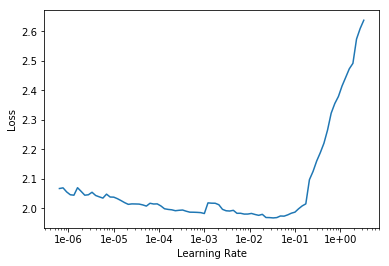

In [50]:
learner.lr_find(); learner.recorder.plot()

In [56]:
learner.fit_one_cycle(20, max_lr=1e-5)

Total time: 00:29
epoch  train_loss  valid_loss  accuracy
1      1.898554    1.914288    0.414322  (00:01)
2      1.750356    1.918710    0.419437  (00:01)
3      1.770898    1.903749    0.409207  (00:01)
4      1.767045    1.907075    0.401535  (00:01)
5      1.786220    1.907977    0.409207  (00:01)
6      1.779734    1.894362    0.419437  (00:01)
7      1.778724    1.891160    0.414322  (00:01)
8      1.799273    1.886593    0.416880  (00:01)
9      1.788211    1.895799    0.409207  (00:01)
10     1.803434    1.916177    0.404092  (00:01)
11     1.800369    1.912988    0.406650  (00:01)
12     1.813180    1.916808    0.404092  (00:01)
13     1.812089    1.915936    0.406650  (00:01)
14     1.813243    1.913247    0.414322  (00:01)
15     1.814424    1.896054    0.414322  (00:01)
16     1.811767    1.886789    0.416880  (00:01)
17     1.880881    1.907061    0.401535  (00:01)
18     1.891300    1.886377    0.414322  (00:01)
19     1.873615    1.901207    0.406650  (00:01)
20     1.88